# BLM Keyword Identification
Sandboxing some simple keyword identification routines.
Full scale work will probably not be done in a notebook, mostly exploration here.

In [96]:
from os import getcwd, listdir
import os.path

import spacy
from scipy import sparse

In [2]:
nlp = spacy.load("en_core_web_lg")

In [123]:
DOC_LIMIT = 20

base_path = os.path.join(getcwd(), "research/data/codex")

file_names = [f for f in listdir(base_path) if os.path.isfile(os.path.join(base_path, f)) and f.endswith(".txt")]

docs_m = dict()
spans_n = dict()

doc_index_m = -1
span_index_n = -1
M = sparse.csr_matrix((0, 0))
for file_name in file_names[:DOC_LIMIT]:
    with open(os.path.join(base_path, file_name), 'r') as f:
        doc = nlp(f.read())
    if not file_name in docs_m:
        doc_index_m = doc_index_m + 1
        docs_m[file_name] = doc_index_m
        M.resize((doc_index_m+1, span_index_n+1))
    spans = spacy.util.filter_spans(
        set(doc.ents).union(set(doc.noun_chunks)))
    spans = [t.lower_ for t in [span for span in spans]]
    for span in spans:
        if not span in spans_n:
            span_index_n = span_index_n + 1
            spans_n[span] = span_index_n  
            M.resize((doc_index_m+1, span_index_n+1))
        M[doc_index_m, span_index_n] = doc.text.lower().count(span)
            
print(M)

  (1, 1)	12.0
  (1, 2)	2.0
  (1, 3)	3.0
  (1, 4)	1.0
  (1, 5)	1.0
  (1, 6)	1.0
  (1, 7)	1.0
  (1, 8)	3.0
  (1, 9)	1.0
  (1, 10)	1.0
  (1, 11)	1.0
  (1, 12)	1.0
  (1, 13)	1.0
  (1, 14)	1.0
  (1, 15)	1.0
  (1, 16)	12.0
  (1, 17)	1.0
  (1, 18)	2.0
  (1, 19)	1.0
  (1, 20)	1.0
  (1, 21)	1.0
  (1, 22)	1.0
  (1, 23)	1.0
  (1, 24)	1.0
  (1, 25)	1.0
  :	:
  (20, 4798)	4.0
  (20, 4799)	1.0
  (20, 4800)	1.0
  (20, 4801)	1.0
  (20, 4802)	2.0
  (20, 4803)	1.0
  (20, 4804)	9.0
  (20, 4805)	1.0
  (20, 4806)	1.0
  (20, 4807)	1.0
  (20, 4808)	1.0
  (20, 4809)	1.0
  (20, 4810)	1.0
  (20, 4811)	1.0
  (20, 4812)	1.0
  (20, 4813)	1.0
  (20, 4814)	1.0
  (20, 4815)	1.0
  (20, 4816)	1.0
  (20, 4817)	1.0
  (20, 4818)	7.0
  (20, 4819)	3.0
  (20, 4820)	2.0
  (20, 4821)	2.0
  (20, 4822)	1.0


In [122]:
print(M[12,62])

0.0


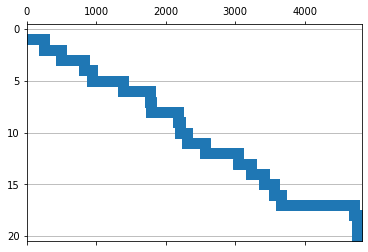

In [166]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spy(M)
ax.grid(b=True, axis='y')
ax.set_aspect('auto')